### Pipeline 1 (biclase): PCA → MLP (baseline)


- Split temporal (train = 70%, val = 15%, test = 15% por orden cronológico).
- StandardScaler + PCA 
- Entrenamiento con `WeightedRandomSampler` 
- Métricas: F1 macro, Balanced Accuracy, MCC, PR-AUC (Attack), reporte, matriz de confusión, curva PR.

> Ajusta la ruta al parquet si hace falta.

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_parquet("../Limpieza_Completada/cicids2017_CleanBinary.parquet")
ts_df = pd.read_parquet("../Timestamp_Datetime_Terminado/Timestamp_Tipo_Datetime.parquet")

#Unión
df["Timestamp"] = ts_df["Timestamp"].values
#Ordenar
df = df.sort_values("Timestamp").reset_index(drop=True)


(2830539, 74)
0   2017-07-03 01:00:01
1   2017-07-03 01:00:01
2   2017-07-03 01:00:01
Name: Timestamp, dtype: datetime64[ns]
2830536   2017-07-07 12:59:00
2830537   2017-07-07 12:59:00
2830538   2017-07-07 12:59:00
Name: Timestamp, dtype: datetime64[ns]
Nulos Timestamp: 0
Attack bincount: [2272894  557645]


### Definir X e y (biclase)
- y sale de Attack.
- X son columnas numéricas.


In [ ]:
y = df["Attack"].astype(np.int64).values

X_df = df.select_dtypes(include=[np.number]).copy()

X_df: (2830539, 71) | y: (2830539,)
Clases y (conteo): [2272894  557645]


### Split temporal (train/val/test)
70% / 15% / 15% en orden cronológico

In [ ]:
n = len(df)
i_train = int(n * 0.70)
i_val   = int(n * 0.85)

X_train_df = X_df.iloc[:i_train]
X_val_df   = X_df.iloc[i_train:i_val]
X_test_df  = X_df.iloc[i_val:]

y_train = y[:i_train]
y_val   = y[i_train:i_val]
y_test  = y[i_val:]

print(X_train_df.shape, X_val_df.shape, X_test_df.shape)
print("Train:", np.bincount(y_train, minlength=2))
print("Val:", np.bincount(y_val, minlength=2))
print("Test:", np.bincount(y_test, minlength=2))

(1981377, 71) (424581, 71) (424581, 71)
Train bincount: [1714580  266797]
Val   bincount: [264157 160424]
Test  bincount: [294157 130424]


### Escalado + PCA (fit solo en train)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_df)
X_val_s   = scaler.transform(X_val_df)
X_test_s  = scaler.transform(X_test_df)

pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train_s)
X_val   = pca.transform(X_val_s)
X_test  = pca.transform(X_test_s)

print("PCA components:", X_train.shape[1])
print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


PCA components: 26
Shapes: (1981377, 26) (424581, 26) (424581, 26)
Guardado: scaler_trainonly.joblib, pca_trainonly.joblib


### Dataset + DataLoaders (con WeightedRandomSampler en TRAIN)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
val_ds   = TabularDataset(X_val, y_val)
test_ds  = TabularDataset(X_test, y_test)

class_counts = np.bincount(y_train, minlength=2)
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights, dtype=torch.float32),
    num_samples=len(sample_weights),
    replacement=True
)

BATCH_SIZE = 2048  
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

print("class_counts:", class_counts)
print("batches:", len(train_loader), len(val_loader), len(test_loader))

class_counts: [1714580  266797]
batches: 967 208 208


### MLP
Usamos `CrossEntropyLoss` simple porque ya balanceamos con sampler.

In [11]:
import torch.nn as nn
import torch.optim as optim

device = torch.device("cpu")

input_dim = X_train.shape[1]
n_classes = 2

class MLP(nn.Module):
    def __init__(self, input_dim, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(input_dim, n_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


### Entrenamiento + selección por métrica en VALIDACIÓN


In [ ]:
from sklearn.metrics import f1_score, average_precision_score

def predict_proba(model, loader):
    model.eval()
    y_true, y_pred, y_proba = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            y_true.append(yb.numpy())
            y_pred.append(np.argmax(probs, axis=1))
            y_proba.append(probs)
    return np.concatenate(y_true), np.concatenate(y_pred), np.concatenate(y_proba)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(len(loader), 1)

def eval_metrics(model, loader):
    y_true, y_pred, y_proba = predict_proba(model, loader)
    f1m = f1_score(y_true, y_pred, average="macro")
    pr_auc_attack = average_precision_score(y_true, y_proba[:, 1])
    return f1m, pr_auc_attack

EPOCHS = 10
best_score = -1.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(model, train_loader)
    f1m_val, pr_val = eval_metrics(model, val_loader)
    print(f"Epoch {epoch}/{EPOCHS} | loss={loss:.4f} | F1_macro(val)={f1m_val:.4f} | PR-AUC_Attack(val)={pr_val:.4f}")

    score = pr_val 
    if score > best_score:
        best_score = score
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

print("Best PR-AUC_Attack(val):", best_score)

model.load_state_dict(best_state)
model.to(device)

Epoch 1/10 | loss=0.0911 | F1_macro(val)=0.3845 | PR-AUC_Attack(val)=0.6672
Epoch 2/10 | loss=0.0435 | F1_macro(val)=0.3823 | PR-AUC_Attack(val)=0.6399
Epoch 3/10 | loss=0.0381 | F1_macro(val)=0.3823 | PR-AUC_Attack(val)=0.6379
Epoch 4/10 | loss=0.0342 | F1_macro(val)=0.3824 | PR-AUC_Attack(val)=0.6461
Epoch 5/10 | loss=0.0317 | F1_macro(val)=0.3822 | PR-AUC_Attack(val)=0.6293
Epoch 6/10 | loss=0.0305 | F1_macro(val)=0.3834 | PR-AUC_Attack(val)=0.6615
Epoch 7/10 | loss=0.0296 | F1_macro(val)=0.3831 | PR-AUC_Attack(val)=0.6855
Epoch 8/10 | loss=0.0283 | F1_macro(val)=0.3827 | PR-AUC_Attack(val)=0.6989
Epoch 9/10 | loss=0.0279 | F1_macro(val)=0.3837 | PR-AUC_Attack(val)=0.7125
Epoch 10/10 | loss=0.0270 | F1_macro(val)=0.3831 | PR-AUC_Attack(val)=0.7292
Best PR-AUC_Attack(val): 0.7291944405752426


MLP(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

### Evaluación en TEST
F1, MCC, PR-AUC (Attack), Balanced Accuracy y matriz de confusión.

In [13]:
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, classification_report, confusion_matrix

y_true, y_pred, y_proba = predict_proba(model, test_loader)

f1_macro = f1_score(y_true, y_pred, average="macro")
bal_acc  = balanced_accuracy_score(y_true, y_pred)
mcc      = matthews_corrcoef(y_true, y_pred)
pr_auc_attack = average_precision_score(y_true, y_proba[:, 1])

print("TEST metrics")
print("F1 macro:", f1_macro)
print("Balanced Accuracy:", bal_acc)
print("MCC:", mcc)
print("PR-AUC (Attack):", pr_auc_attack)

print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

TEST metrics
F1 macro: 0.6784995147537201
Balanced Accuracy: 0.6612667915726307
MCC: 0.4800930541210471
PR-AUC (Attack): 0.9309802681345163

Classification report:
               precision    recall  f1-score   support

           0     0.7697    0.9914    0.8666    294157
           1     0.9449    0.3311    0.4904    130424

    accuracy                         0.7886    424581
   macro avg     0.8573    0.6613    0.6785    424581
weighted avg     0.8235    0.7886    0.7511    424581

Confusion matrix:
 [[291638   2519]
 [ 87241  43183]]


### Curva Precision-Recall en TEST

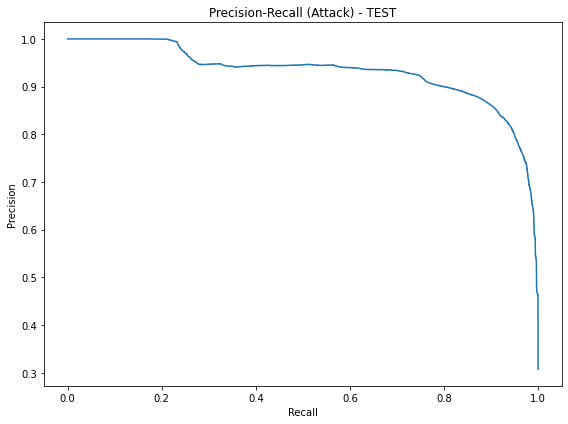

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(y_true, y_proba[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(rec, prec)
plt.title("Precision-Recall (Attack) - TEST")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()